In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

# library for sampling 
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE, SVMSMOTE

# library for machine learning
import sklearn
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold, GridSearchCV
from sklearn.metrics import roc_auc_score, RocCurveDisplay, confusion_matrix, precision_recall_fscore_support, confusion_matrix, roc_curve, make_scorer
from sklearn.neural_network import MLPClassifier

import shap

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

c:\Users\jongb\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
X_base = pd.read_csv(r"C:\Users\bank_marketing\data\X_base.csv")
y_encoded = pd.read_csv(r"C:\Users\bank_marketing\data\Y_encoded.csv")

In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    X_base, y_encoded, test_size=0.2, stratify=y_encoded
)

## 1. Model Optimization

In [4]:
LOCAL_HOST = "http://"
EXPERIMENT_NAME = "bank_marketing_model"

In [5]:
import mlflow

mlflow.set_tracking_uri(LOCAL_HOST)
mlflow.create_experiment(EXPERIMENT_NAME)

'830362473760211760'

In [6]:
mlflow.set_experiment(EXPERIMENT_NAME)

<Experiment: artifact_location='mlflow-artifacts:/830362473760211760', creation_time=1734936396916, experiment_id='830362473760211760', last_update_time=1734936396916, lifecycle_stage='active', name='bank_marketing_model', tags={}>

In [7]:
# Parameters
RANDOM_STATE = 42
N_SPLIT = 3

HIDDEN_LAYER = 10
ACTIVATION = "relu"
MAX_ITER = 500
LEARNING_RATE = 0.001
SAMPLING = None

### 1-1. Base Model withouth sampling

Fold 1
val_precision: 0.7819630569375758 val_recall: 0.7286412789282789 val_f1: 0.7513543959505229
val_auc score: 0.9380202157451349
Fold 2
val_precision: 0.7862230107956818 val_recall: 0.7318812561239374 val_f1: 0.7550235055467023
val_auc score: 0.9374199879506386
Fold 3
val_precision: 0.7795337065909009 val_recall: 0.7428593096417875 val_f1: 0.7593507725627617
val_auc score: 0.9401288125023285
=================Test score =====================
test_precision: 0.7833525859160468 test_recall: 0.7243944991789819 test_f1: 0.749039171511807
test_auc score: 0.940899970273484


<Figure size 640x480 with 0 Axes>

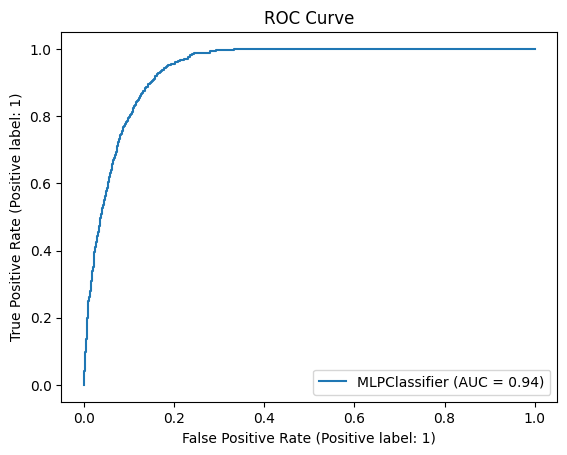

<Figure size 640x480 with 0 Axes>

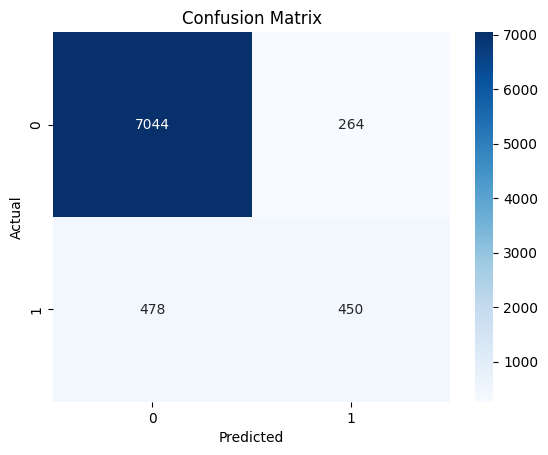

2024/12/23 07:47:11 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run legendary-panda-290 at: http://127.0.0.1:5000/#/experiments/830362473760211760/runs/5998b6ab2a104ab1b1b5a15f23265809
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/830362473760211760


<Figure size 640x480 with 0 Axes>

In [8]:
with mlflow.start_run():

    skf = StratifiedKFold(n_splits=N_SPLIT, random_state=RANDOM_STATE, shuffle=True)

    # Logging parameters
    mlflow.log_param("split_num", N_SPLIT)
    mlflow.log_param("hidden_layer_sizes", HIDDEN_LAYER)
    mlflow.log_param("activation", ACTIVATION)
    mlflow.log_param("learning_rate_init", LEARNING_RATE)
    mlflow.log_param("sampling", SAMPLING)

    # Metrics collection
    list_fold_result_val, list_fold_result_test = [], []
    list_fold_roc_val, list_fold_roc_test = [], []

    for i, (train_index, val_index) in enumerate(skf.split(X_train, y_train)):
        print(f"Fold {i+1}")

        # Data split
        X_train_cv, X_val_cv = X_train.iloc[train_index, :], X_train.iloc[val_index, :]
        y_train_cv, y_val_cv = y_train.iloc[train_index], y_train.iloc[val_index]

        y_train_cv = (
            y_train_cv.values.ravel()
            if isinstance(y_train_cv, pd.DataFrame)
            else y_train_cv.ravel()
        )
        y_val_cv = (
            y_val_cv.values.ravel()
            if isinstance(y_val_cv, pd.DataFrame)
            else y_val_cv.ravel()
        )

        # Model training
        model = MLPClassifier(
            hidden_layer_sizes=HIDDEN_LAYER,
            activation=ACTIVATION,
            learning_rate_init=LEARNING_RATE,
            max_iter=MAX_ITER,
            random_state=RANDOM_STATE,
        )
        model.fit(X_train_cv, y_train_cv)

        # Validation set evaluation
        y_pred_val = model.predict(X_val_cv)
        y_pred_proba_val = model.predict_proba(X_val_cv)[:, -1]
        roc_val = roc_auc_score(y_val_cv, y_pred_proba_val)
        prf_val = precision_recall_fscore_support(y_val_cv, y_pred_val, average="macro")

        print(
            f"val_precision: {prf_val[0]} val_recall: {prf_val[1]} val_f1: {prf_val[2]}"
        )
        print(f"val_auc score: {roc_val}")

        list_fold_result_val.append(prf_val)
        list_fold_roc_val.append(roc_val)

    # Average metrics calculation
    def get_prf_average(results, n_split):
        pre, rec, f1 = 0, 0, 0
        for res in results:
            pre += res[0]
            rec += res[1]
            f1 += res[2]
        return pre / n_split, rec / n_split, f1 / n_split

    val_precision, val_recall, val_f1 = get_prf_average(list_fold_result_val, N_SPLIT)
    val_roc = sum(list_fold_roc_val) / N_SPLIT

    # test set evaluation
    y_pred_test = model.predict(X_test)
    y_pred_proba_test = model.predict_proba(X_test)[:, -1]
    test_roc = roc_auc_score(y_test, y_pred_proba_test)
    prf_test = precision_recall_fscore_support(y_test, y_pred_test, average="macro")

    test_precision = prf_test[0]
    test_recall = prf_test[1]
    test_f1 = prf_test[2]
    print("=================Test score =====================")
    print(
        f"test_precision: {test_precision} test_recall: {test_recall} test_f1: {test_f1}"
    )
    print(f"test_auc score: {test_roc}")

    # Log metrics
    mlflow.log_metric("precision_on_val", val_precision)
    mlflow.log_metric("recall_on_val", val_recall)
    mlflow.log_metric("f1score_on_val", val_f1)
    mlflow.log_metric("roc_on_val", val_roc)

    mlflow.log_metric("precision_on_test", test_precision)
    mlflow.log_metric("recall_on_test", test_recall)
    mlflow.log_metric("f1score_on_test", test_f1)
    mlflow.log_metric("roc_on_test", test_roc)

    def save_artifacts(model, X, y, pred):
        # ROC Curve
        plt.figure()
        roc_display = RocCurveDisplay.from_estimator(model, X, y)
        roc_display.ax_ = plt.gca()
        roc_display.figure_ = plt.gcf()
        plt.title("ROC Curve")
        plt.savefig("roc_curve.png")
        plt.show()
        plt.clf()
        mlflow.log_artifact("roc_curve.png")

        # Confusion Matrix
        conf_matrix = confusion_matrix(y, pred)
        plt.figure()
        sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
        plt.ylabel("Actual")
        plt.xlabel("Predicted")
        plt.title("Confusion Matrix")
        plt.savefig("conf_matrix.png")
        plt.show()
        plt.clf()
        mlflow.log_artifact("conf_matrix.png")

    save_artifacts(model, X_test, y_test, y_pred_test)
    mlflow.sklearn.log_model(model, "model")

mlflow.end_run()

##### Final Features Characteristics:
1. Feature selection conducted using Chi-square test, correlation analysis, and Kruskal-Wallis test.
2. Feature transformation applied.
3. Sampling methods used (oversampling, combined sampling).

##### Types of Features:
1. **X_base, Y_encoded**: No sampling applied, imbalanced data (experiment already completed).
2. **X_sm_sampling, Y_sm_sampling**: SMOTE oversampling applied.
3. **X_csm_sampling, Y_csm_sampling**: SMOTEENN combined sampling applied.

### 2.Sampling 
- SMOTE
- SMOTEEN

In [9]:
# 1. SMOTE
sm = SMOTE(random_state=RANDOM_STATE)
X_sm_sampling, y_sm_sampling = sm.fit_resample(X_train, y_train)

In [10]:
# 2. SMOTEEN
combined_sm = SMOTEENN(random_state=RANDOM_STATE)
X_csm_sampling, y_csm_sampling = combined_sm.fit_resample(X_train, y_train)

### 1-2 model optimization with smote oversampling


Fold 1
val_precision: 0.9359602993110823 val_recall: 0.9358513804782922 val_f1: 0.9358473735599997
val_auc score: 0.9867984708812647
Fold 2
val_precision: 0.9396241823866764 val_recall: 0.9394950220671251 val_f1: 0.939490577693593
val_auc score: 0.9880429132787355
Fold 3
val_precision: 0.9343374567353584 val_recall: 0.9340039002360669 val_f1: 0.9339912271089472
val_auc score: 0.9863852228801812
=================Test score =====================
test_precision: 0.7492322849819815 test_recall: 0.8051193897099069 test_f1: 0.772783255142395
test_auc score: 0.9364317033293699


<Figure size 640x480 with 0 Axes>

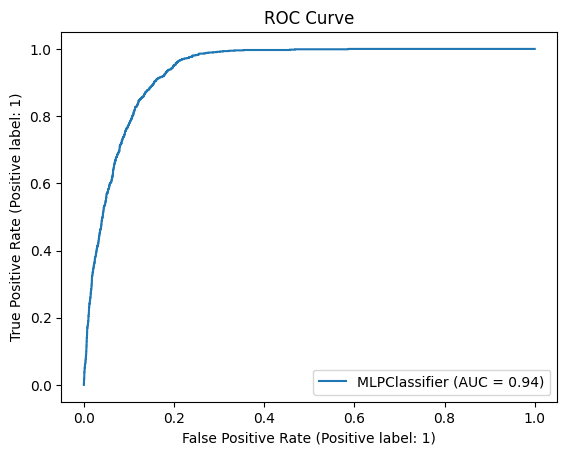

<Figure size 640x480 with 0 Axes>

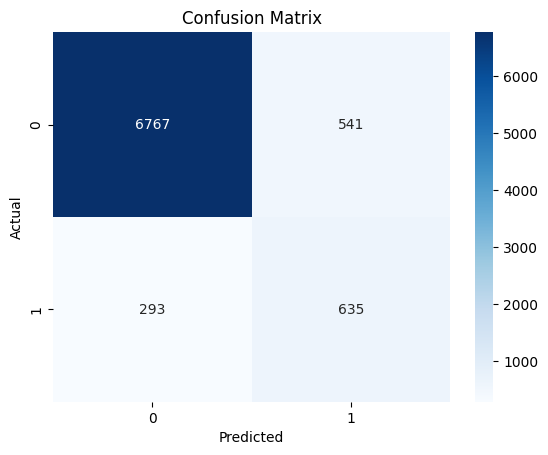

2024/12/23 07:48:03 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run wise-trout-905 at: http://127.0.0.1:5000/#/experiments/830362473760211760/runs/e242854578ed46aa867796084d7a4fad
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/830362473760211760


<Figure size 640x480 with 0 Axes>

In [11]:
SAMPLING = "SMOTE"

with mlflow.start_run():

    skf = StratifiedKFold(n_splits=N_SPLIT, random_state=RANDOM_STATE, shuffle=True)

    # Logging parameters
    mlflow.log_param("split_num", N_SPLIT)
    mlflow.log_param("hidden_layer_sizes", HIDDEN_LAYER)
    mlflow.log_param("activation", ACTIVATION)
    mlflow.log_param("learning_rate_init", LEARNING_RATE)
    mlflow.log_param("sampling", SAMPLING)

    # Metrics collection
    list_fold_result_val, list_fold_result_test = [], []
    list_fold_roc_val, list_fold_roc_test = [], []

    for i, (train_index, val_index) in enumerate(
        skf.split(X_sm_sampling, y_sm_sampling)
    ):
        print(f"Fold {i+1}")

        # Data split
        X_train_cv, X_val_cv = (
            X_sm_sampling.iloc[train_index, :],
            X_sm_sampling.iloc[val_index, :],
        )
        y_train_cv, y_val_cv = (
            y_sm_sampling.iloc[train_index],
            y_sm_sampling.iloc[val_index],
        )

        y_train_cv = (
            y_train_cv.values.ravel()
            if isinstance(y_train_cv, pd.DataFrame)
            else y_train_cv.ravel()
        )
        y_val_cv = (
            y_val_cv.values.ravel()
            if isinstance(y_val_cv, pd.DataFrame)
            else y_val_cv.ravel()
        )

        # Model training
        model = MLPClassifier(
            hidden_layer_sizes=HIDDEN_LAYER,
            activation=ACTIVATION,
            learning_rate_init=LEARNING_RATE,
            max_iter=MAX_ITER,
            random_state=RANDOM_STATE,
        )
        model.fit(X_train_cv, y_train_cv)

        # Validation set evaluation
        y_pred_val = model.predict(X_val_cv)
        y_pred_proba_val = model.predict_proba(X_val_cv)[:, -1]
        roc_val = roc_auc_score(y_val_cv, y_pred_proba_val)
        prf_val = precision_recall_fscore_support(y_val_cv, y_pred_val, average="macro")

        print(
            f"val_precision: {prf_val[0]} val_recall: {prf_val[1]} val_f1: {prf_val[2]}"
        )
        print(f"val_auc score: {roc_val}")

        list_fold_result_val.append(prf_val)
        list_fold_roc_val.append(roc_val)

    # Average metrics calculation
    def get_prf_average(results, n_split):
        pre, rec, f1 = 0, 0, 0
        for res in results:
            pre += res[0]
            rec += res[1]
            f1 += res[2]
        return pre / n_split, rec / n_split, f1 / n_split

    val_precision, val_recall, val_f1 = get_prf_average(list_fold_result_val, N_SPLIT)
    val_roc = sum(list_fold_roc_val) / N_SPLIT

    # test set evaluation
    y_pred_test = model.predict(X_test)
    y_pred_proba_test = model.predict_proba(X_test)[:, -1]
    test_roc = roc_auc_score(y_test, y_pred_proba_test)
    prf_test = precision_recall_fscore_support(y_test, y_pred_test, average="macro")

    test_precision = prf_test[0]
    test_recall = prf_test[1]
    test_f1 = prf_test[2]
    print("=================Test score =====================")
    print(
        f"test_precision: {test_precision} test_recall: {test_recall} test_f1: {test_f1}"
    )
    print(f"test_auc score: {test_roc}")

    # Log metrics
    mlflow.log_metric("precision_on_val", val_precision)
    mlflow.log_metric("recall_on_val", val_recall)
    mlflow.log_metric("f1score_on_val", val_f1)
    mlflow.log_metric("roc_on_val", val_roc)

    mlflow.log_metric("precision_on_test", test_precision)
    mlflow.log_metric("recall_on_test", test_recall)
    mlflow.log_metric("f1score_on_test", test_f1)
    mlflow.log_metric("roc_on_test", test_roc)

    def save_artifacts(model, X, y, pred):
        # ROC Curve
        plt.figure()
        roc_display = RocCurveDisplay.from_estimator(model, X, y)
        roc_display.ax_ = plt.gca()
        roc_display.figure_ = plt.gcf()
        plt.title("ROC Curve")
        plt.savefig("roc_curve.png")
        plt.show()
        plt.clf()
        mlflow.log_artifact("roc_curve.png")

        # Confusion Matrix
        conf_matrix = confusion_matrix(y, pred)
        plt.figure()
        sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
        plt.ylabel("Actual")
        plt.xlabel("Predicted")
        plt.title("Confusion Matrix")
        plt.savefig("conf_matrix.png")
        plt.show()
        plt.clf()
        mlflow.log_artifact("conf_matrix.png")

    save_artifacts(model, X_test, y_test, y_pred_test)
    mlflow.sklearn.log_model(model, "model")

mlflow.end_run()

### 1-3 model optimization with SMOTEEN

Fold 1
val_precision: 0.9685270665974869 val_recall: 0.9684912416056333 val_f1: 0.9685090892417072
val_auc score: 0.9960550981615482
Fold 2
val_precision: 0.9697281603319228 val_recall: 0.9678312821477941 val_f1: 0.9686431787116172
val_auc score: 0.9959803743557187
Fold 3
val_precision: 0.9706476453265127 val_recall: 0.9699823182991107 val_f1: 0.970295041146942
val_auc score: 0.9960712927240125
=================Test score =====================
test_precision: 0.7271792533749585 test_recall: 0.8251231527093597 test_f1: 0.761760449933082
test_auc score: 0.9313130213936546


<Figure size 640x480 with 0 Axes>

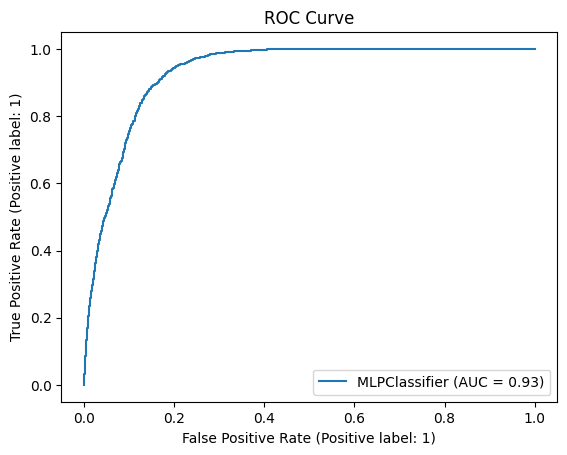

<Figure size 640x480 with 0 Axes>

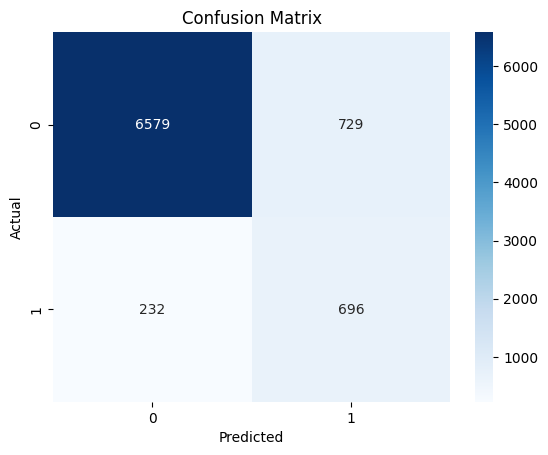

2024/12/23 07:48:54 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run dapper-carp-198 at: http://127.0.0.1:5000/#/experiments/830362473760211760/runs/b7fba6c45be84cc2bc3c7d40be5d475d
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/830362473760211760


<Figure size 640x480 with 0 Axes>

In [12]:
SAMPLING = "SMOTEEN"

with mlflow.start_run():

    skf = StratifiedKFold(n_splits=N_SPLIT, random_state=RANDOM_STATE, shuffle=True)

    # Logging parameters
    mlflow.log_param("split_num", N_SPLIT)
    mlflow.log_param("hidden_layer_sizes", HIDDEN_LAYER)
    mlflow.log_param("activation", ACTIVATION)
    mlflow.log_param("learning_rate_init", LEARNING_RATE)
    mlflow.log_param("sampling", SAMPLING)

    # Metrics collection
    list_fold_result_val, list_fold_result_test = [], []
    list_fold_roc_val, list_fold_roc_test = [], []

    for i, (train_index, val_index) in enumerate(
        skf.split(X_csm_sampling, y_csm_sampling)
    ):
        print(f"Fold {i+1}")

        # Data split
        X_train_cv, X_val_cv = (
            X_csm_sampling.iloc[train_index, :],
            X_csm_sampling.iloc[val_index, :],
        )
        y_train_cv, y_val_cv = (
            y_csm_sampling.iloc[train_index],
            y_csm_sampling.iloc[val_index],
        )

        y_train_cv = (
            y_train_cv.values.ravel()
            if isinstance(y_train_cv, pd.DataFrame)
            else y_train_cv.ravel()
        )
        y_val_cv = (
            y_val_cv.values.ravel()
            if isinstance(y_val_cv, pd.DataFrame)
            else y_val_cv.ravel()
        )

        # Model training
        model = MLPClassifier(
            hidden_layer_sizes=HIDDEN_LAYER,
            activation=ACTIVATION,
            learning_rate_init=LEARNING_RATE,
            max_iter=MAX_ITER,
            random_state=RANDOM_STATE,
        )
        model.fit(X_train_cv, y_train_cv)

        # Validation set evaluation
        y_pred_val = model.predict(X_val_cv)
        y_pred_proba_val = model.predict_proba(X_val_cv)[:, -1]
        roc_val = roc_auc_score(y_val_cv, y_pred_proba_val)
        prf_val = precision_recall_fscore_support(y_val_cv, y_pred_val, average="macro")

        print(
            f"val_precision: {prf_val[0]} val_recall: {prf_val[1]} val_f1: {prf_val[2]}"
        )
        print(f"val_auc score: {roc_val}")

        list_fold_result_val.append(prf_val)
        list_fold_roc_val.append(roc_val)

    # Average metrics calculation
    def get_prf_average(results, n_split):
        pre, rec, f1 = 0, 0, 0
        for res in results:
            pre += res[0]
            rec += res[1]
            f1 += res[2]
        return pre / n_split, rec / n_split, f1 / n_split

    val_precision, val_recall, val_f1 = get_prf_average(list_fold_result_val, N_SPLIT)
    val_roc = sum(list_fold_roc_val) / N_SPLIT

    # test set evaluation
    y_pred_test = model.predict(X_test)
    y_pred_proba_test = model.predict_proba(X_test)[:, -1]
    test_roc = roc_auc_score(y_test, y_pred_proba_test)
    prf_test = precision_recall_fscore_support(y_test, y_pred_test, average="macro")

    test_precision = prf_test[0]
    test_recall = prf_test[1]
    test_f1 = prf_test[2]
    print("=================Test score =====================")
    print(
        f"test_precision: {test_precision} test_recall: {test_recall} test_f1: {test_f1}"
    )
    print(f"test_auc score: {test_roc}")

    # Log metrics
    mlflow.log_metric("precision_on_val", val_precision)
    mlflow.log_metric("recall_on_val", val_recall)
    mlflow.log_metric("f1score_on_val", val_f1)
    mlflow.log_metric("roc_on_val", val_roc)

    mlflow.log_metric("precision_on_test", test_precision)
    mlflow.log_metric("recall_on_test", test_recall)
    mlflow.log_metric("f1score_on_test", test_f1)
    mlflow.log_metric("roc_on_test", test_roc)

    def save_artifacts(model, X, y, pred):
        # ROC Curve
        plt.figure()
        roc_display = RocCurveDisplay.from_estimator(model, X, y)
        roc_display.ax_ = plt.gca()
        roc_display.figure_ = plt.gcf()
        plt.title("ROC Curve")
        plt.savefig("roc_curve.png")
        plt.show()
        plt.clf()
        mlflow.log_artifact("roc_curve.png")

        # Confusion Matrix
        conf_matrix = confusion_matrix(y, pred)
        plt.figure()
        sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
        plt.ylabel("Actual")
        plt.xlabel("Predicted")
        plt.title("Confusion Matrix")
        plt.savefig("conf_matrix.png")
        plt.show()
        plt.clf()
        mlflow.log_artifact("conf_matrix.png")

    save_artifacts(model, X_test, y_test, y_pred_test)
    mlflow.sklearn.log_model(model, "model")

mlflow.end_run()

In [13]:
# Custom scorer for GridSearchCV
def precision_macro_scorer(y_true, y_pred):
    precision, _, _, _ = precision_recall_fscore_support(
        y_true, y_pred, average="macro"
    )
    return precision


def recall_macro_scorer(y_true, y_pred):
    _, recall, _, _ = precision_recall_fscore_support(y_true, y_pred, average="macro")
    return recall


def f1_macro_scorer(y_true, y_pred):
    _, _, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="macro")
    return f1


scoring = {
    "roc_auc": make_scorer(roc_auc_score, needs_proba=True, average="macro"),
    "precision_macro": make_scorer(precision_macro_scorer),
    "recall_macro": make_scorer(recall_macro_scorer),
    "f1_macro": make_scorer(f1_macro_scorer),
}

Fitting 3 folds for each of 9 candidates, totalling 27 fits
================= Test Scores =====================
Precision: 0.7139418701673192, Recall: 0.8001932813355227, F1: 0.7449546422850433, ROC AUC: 0.919948969480777


<Figure size 640x480 with 0 Axes>

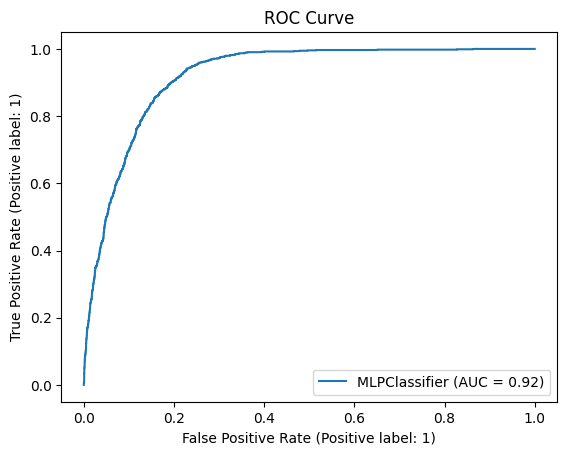

<Figure size 640x480 with 0 Axes>

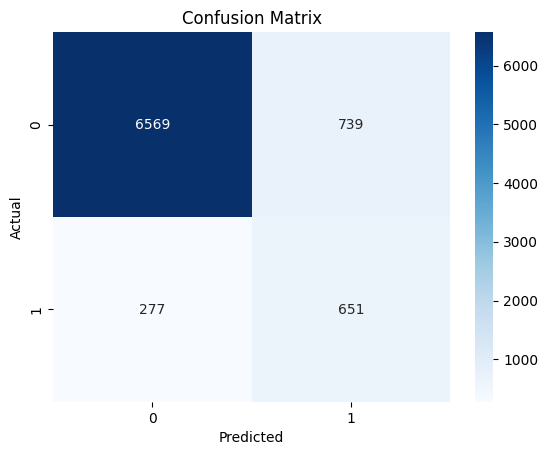

2024/12/23 07:54:01 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run fortunate-skunk-42 at: http://127.0.0.1:5000/#/experiments/830362473760211760/runs/78cc0600c7f04c339014e81b0e984540
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/830362473760211760


<Figure size 640x480 with 0 Axes>

In [14]:
# Hyperparameter grid
param_grid = {
    "hidden_layer_sizes": [10, 20, 30],
    "learning_rate_init": [0.002, 0.01, 0.1],
    "activation": ["relu"],
}

# StratifiedKFold CV
cv = StratifiedKFold(n_splits=N_SPLIT, shuffle=True, random_state=RANDOM_STATE)

# Initialize the model
mlp = MLPClassifier(max_iter=MAX_ITER, random_state=RANDOM_STATE)

# GridSearchCV
grid_search = GridSearchCV(
    estimator=mlp,
    param_grid=param_grid,
    scoring=scoring,
    refit="roc_auc",  # Optimize for ROC AUC
    cv=cv,
    verbose=1,
    return_train_score=True,
)

with mlflow.start_run():
    # Log static parameters
    mlflow.log_param("sampling", SAMPLING)

    # Fit the GridSearchCV
    grid_search.fit(X_csm_sampling, y_csm_sampling)

    # Log the best parameters
    best_params = grid_search.best_params_
    mlflow.log_param("best_hidden_layer_sizes", best_params["hidden_layer_sizes"])
    mlflow.log_param("best_learning_rate_init", best_params["learning_rate_init"])
    mlflow.log_param("best_activation", best_params["activation"])

    # Log the best scores
    best_roc_auc = grid_search.best_score_
    mlflow.log_metric("best_roc_auc", best_roc_auc)

    # Best model evaluation on test set
    best_model = grid_search.best_estimator_
    y_pred_test = best_model.predict(X_test)
    y_pred_proba_test = best_model.predict_proba(X_test)[:, -1]
    test_roc = roc_auc_score(y_test, y_pred_proba_test)
    prf_test = precision_recall_fscore_support(y_test, y_pred_test, average="macro")

    test_precision, test_recall, test_f1 = prf_test[0], prf_test[1], prf_test[2]

    # Log test metrics
    mlflow.log_metric("precision_on_test", test_precision)
    mlflow.log_metric("recall_on_test", test_recall)
    mlflow.log_metric("f1score_on_test", test_f1)
    mlflow.log_metric("roc_on_test", test_roc)

    print("================= Test Scores =====================")
    print(
        f"Precision: {test_precision}, Recall: {test_recall}, F1: {test_f1}, ROC AUC: {test_roc}"
    )

    # Save artifacts
    def save_artifacts(model, X, y, pred):
        # ROC Curve
        plt.figure()
        RocCurveDisplay.from_estimator(model, X, y)
        plt.title("ROC Curve")
        plt.savefig("roc_curve.png")
        plt.show()
        plt.clf()
        mlflow.log_artifact("roc_curve.png")

        # Confusion Matrix
        conf_matrix = confusion_matrix(y, pred)
        plt.figure()
        sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
        plt.ylabel("Actual")
        plt.xlabel("Predicted")
        plt.title("Confusion Matrix")
        plt.savefig("conf_matrix.png")
        plt.show()
        plt.clf()
        mlflow.log_artifact("conf_matrix.png")

    save_artifacts(best_model, X_test, y_test, y_pred_test)

    # Log the best model
    mlflow.sklearn.log_model(best_model, "best_model")

mlflow.end_run()